# DETECTING COVID-19 with CHEST X RAY using PyTorch

image classification of Chest X Rays in one of three classes: normal, viral pneumonia, COVID-19


dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) and trained on [resnet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)

## Importing Libraries

In [3]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(42)

print('PyTorch version', torch.__version__)

PyTorch version 2.3.1+cu121


## Preparing Training and Test Sets

In [4]:
root = 'covid-19-radiography-database'
source = ['COVID', 'normal', 'viral pneumonia']
classes = ['COVID', 'normal', 'viral pneumonia']


if os.path.isdir(os.path.join(root, source[1])):
    test = os.path.join(root, 'test')
    if not os.path.exists(test):
        os.mkdir(test)

    for i, d in enumerate(source):
        os.rename(os.path.join(root, d), os.path.join(root, classes[i]))

    for c in classes:
        classtest = os.path.join(test, c)
        if not os.path.exists(classtest):
            os.mkdir(classtest)
            
    for c in classes:
        images = [x for x in os.listdir(os.path.join(root, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root, c, image)
            target_path = os.path.join(root, 'test', c, image)
            shutil.move(source_path, target_path)

## Creating Custom Dataset

In [5]:
class ChestXRayDataset(torch.utils.data.Dataset):
    
    # c refers to a class name in classes
    
    def __init__(self, directories, transform):
        def getimages(c):
            images = [x for x in os.listdir(directories[c]) if x[-3:].lower().endswith('png')]
            print(f'found examples of {c}: {len(images)}')
            return images
        
        self.images = {}
        self.classes = ['covid', 'normal', 'viral pneumonia']
        
        for c in self.classes:
            self.images[c] = getimages(c)
            
        self.transform = transform
        self.directories = directories
            
    def __len__(self):
        return sum([len(self.images[c]) for c in self.classes])
    
    
    def __getitem__(self, index):
        c = random.choice(self.classes)
        index = index % len(self.images[c])
        image_name = self.images[c][index]
        image_path = os.path.join(self.directories[c], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.classes.index(c)

## Image Transformations

In [6]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 244)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [7]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 244)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

## Prepare Dataloader

In [8]:
directory_train = {
    'covid': 'covid-19-radiography-database/covid',
    'normal': 'covid-19-radiography-database/normal',
    'viral pneumonia': 'covid-19-radiography-database/viral pneumonia'
}

train_dataset = ChestXRayDataset(directory_train, transform_train)

found examples of covid: 2776
found examples of normal: 9352
found examples of viral pneumonia: 505


In [9]:
directory_test = {
    'covid': 'covid-19-radiography-database/test/covid',
    'normal': 'covid-19-radiography-database/test/normal',
    'viral pneumonia': 'covid-19-radiography-database/test/viral pneumonia'
}

test_dataset = ChestXRayDataset(directory_test, transform_test)

found examples of covid: 840
found examples of normal: 840
found examples of viral pneumonia: 840


In [10]:
batch_size = 6

dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print('number of testing batches', len(dataloader_test))
print('number of training batches', len(dataloader_train))

number of testing batches 420
number of training batches 2106


## Data Visualization

In [11]:
classes = train_dataset.classes

def showimages(images, labels, predictions):
    plt.figure(figsize=(10,5))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        col = 'green'
        if predictions[i] != labels[i]:
            col = 'red'
        plt.xlabel(f'{classes[int(labels[i].numpy())]}')
        plt.ylabel(f'{classes[int(predictions[i].numpy())]}', color=col)
        plt.tight_layout()
    plt.show()

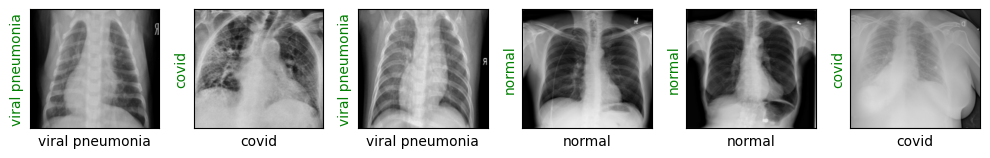

In [12]:
images, labels = next(iter(dataloader_train))
showimages(images, labels, labels)

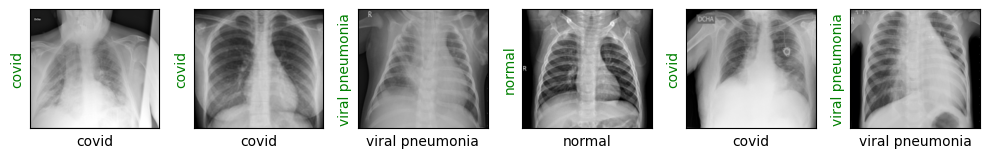

In [13]:
images, labels = next(iter(dataloader_test))
showimages(images, labels, labels)

## Creating the Model

In [14]:
resnet18 = torchvision.models.resnet18(weights="IMAGENET1K_V1", progress=True)
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [16]:
def showpredictions():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet18.to(device)
    resnet18.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader_test))
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = resnet18(images)
        _, predictions = torch.max(outputs, 1)
        
        images = images.cpu()
        labels = labels.cpu()
        predictions = predictions.cpu()
        
        showimages(images, labels, predictions)

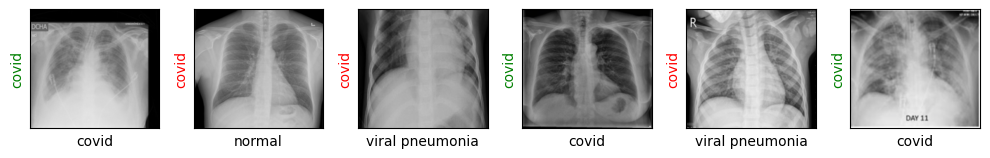

In [17]:
showpredictions()

## Training the Model

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

def train(epochs):
    print('training starting...')
    
    for e in range(0,epochs):
        print(f'epoch {e+1}/{epochs}')
        loss_train = 0
        loss_valid = 0
        
        resnet18.train()
        
        for step_train, (images, labels) in enumerate(dataloader_train):
            images, labels = images.to(device), labels.to(device)            
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
            if step_train % 20 == 0:
                print('evaluating step', step_train)
                accuracy = 0
                
                resnet18.eval()
            
                for step_valid, (images, labels) in enumerate(dataloader_test):
                    images, labels = images.to(device), labels.to(device)            
                    outputs = resnet18(images)
                    loss = loss_func(outputs, labels)
                    loss_valid += loss.item()
                    _, predictions = torch.max(outputs, 1)
                    accuracy += (predictions == labels).sum().cpu().item()
                
                loss_valid /= (step_valid + 1)
                accuracy /= len(test_dataset)
                print(f'validation loss: {loss_valid:.4f}, accuracy: {accuracy:.4f}')
                
                showpredictions()
                
                resnet18.train()
                
                if accuracy >= 0.95:
                    print('training stopping')
                    break
                
                loss_train /= (step_train + 1)

        print(f'training loss: {loss_train:.4f}')
                          
    print('training completed...')

training starting...
epoch 1/1
evaluating step 0
validation loss: 1.3527, accuracy: 0.3286


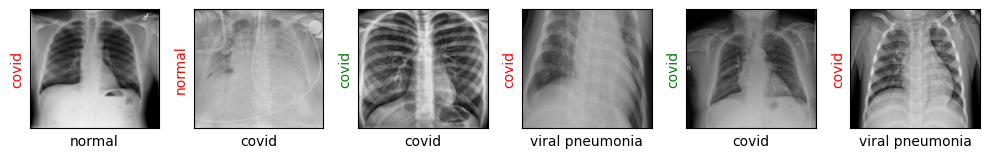

evaluating step 20
validation loss: 0.7787, accuracy: 0.6885


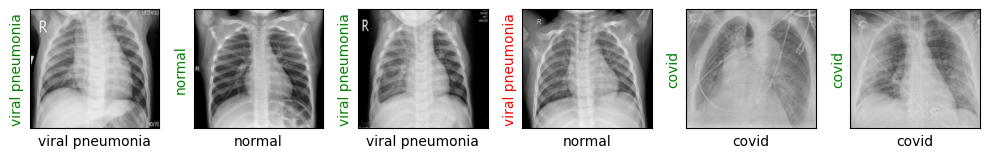

evaluating step 40
validation loss: 0.5336, accuracy: 0.8214


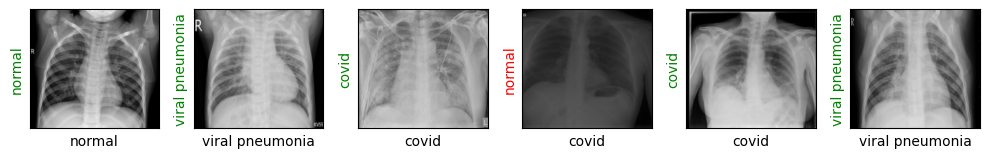

evaluating step 60
validation loss: 0.3736, accuracy: 0.8722


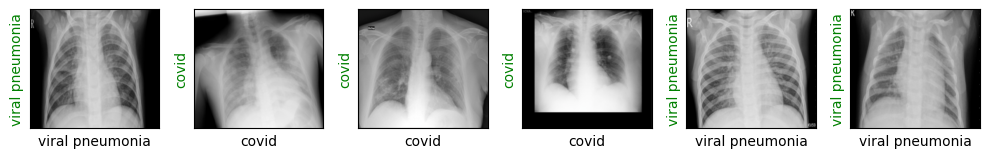

evaluating step 80
validation loss: 0.2941, accuracy: 0.8956


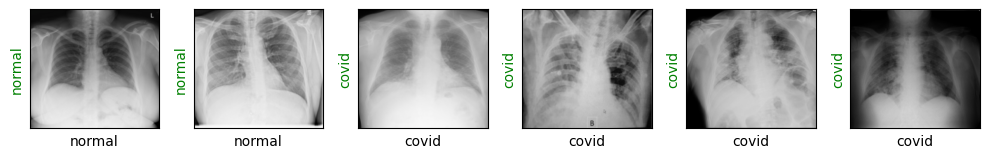

evaluating step 100
validation loss: 0.2717, accuracy: 0.9016


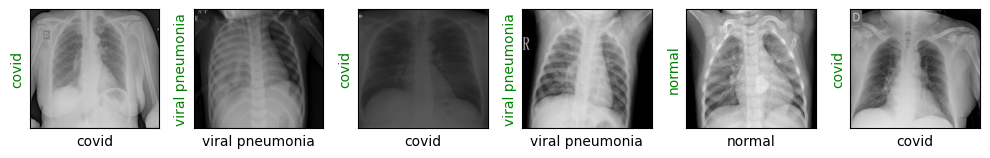

evaluating step 120
validation loss: 0.3195, accuracy: 0.8476


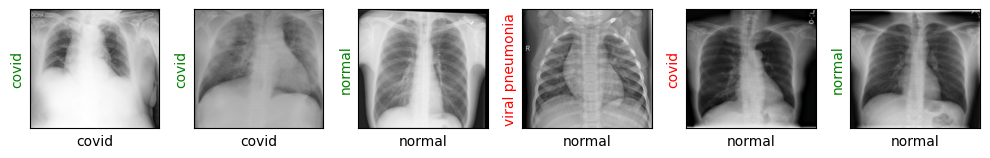

evaluating step 140
validation loss: 0.2290, accuracy: 0.9194


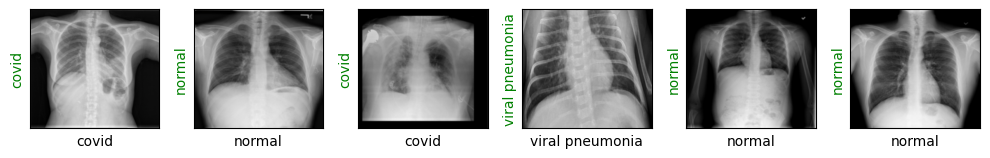

evaluating step 160
validation loss: 0.2053, accuracy: 0.9317


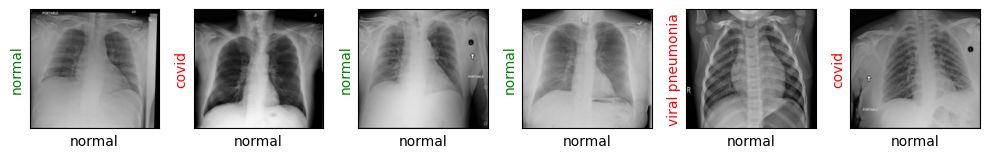

evaluating step 180
validation loss: 0.1865, accuracy: 0.9353


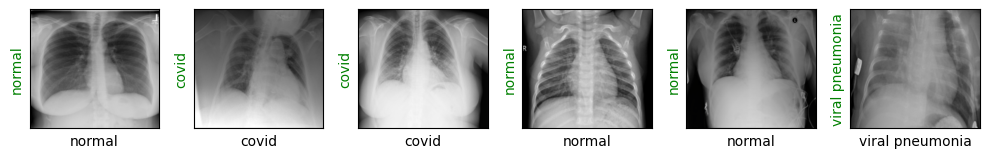

evaluating step 200
validation loss: 0.1823, accuracy: 0.9417


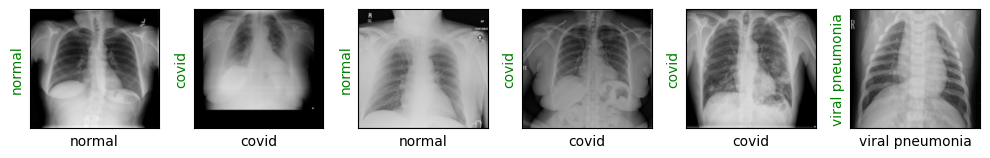

evaluating step 220
validation loss: 0.2204, accuracy: 0.9143


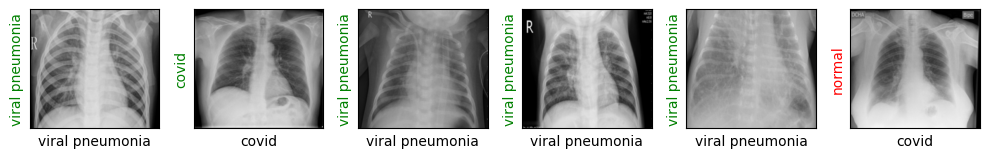

evaluating step 240
validation loss: 0.1690, accuracy: 0.9401


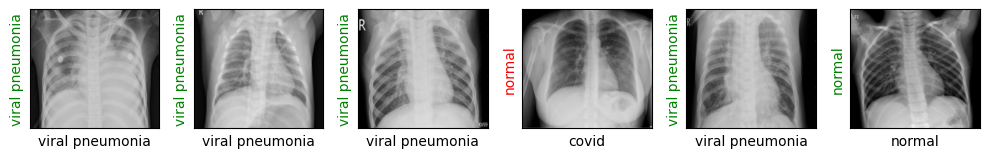

evaluating step 260
validation loss: 0.1677, accuracy: 0.9413


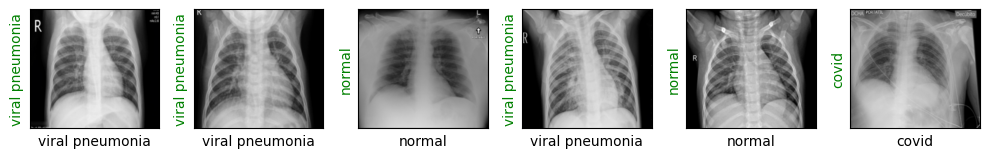

evaluating step 280
validation loss: 0.1771, accuracy: 0.9310


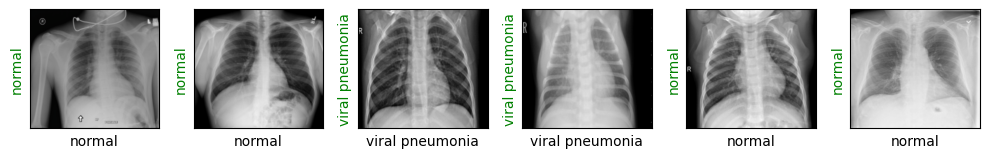

evaluating step 300
validation loss: 0.1807, accuracy: 0.9278


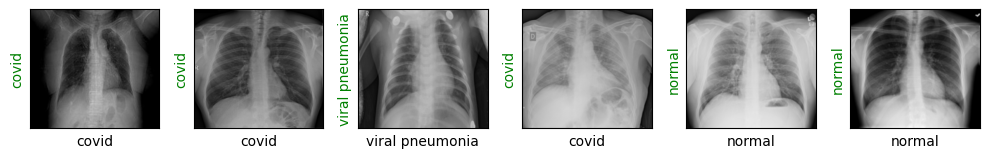

evaluating step 320
validation loss: 0.1478, accuracy: 0.9536


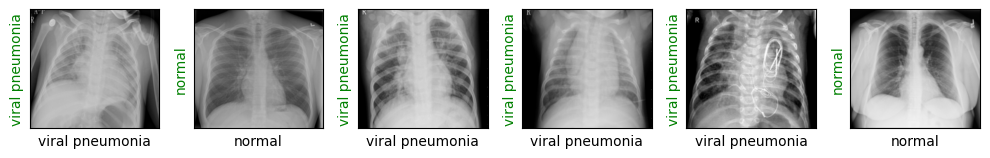

training stopping
training loss: 5.3329
training completed...


In [19]:
train(epochs=1)

## Final Results

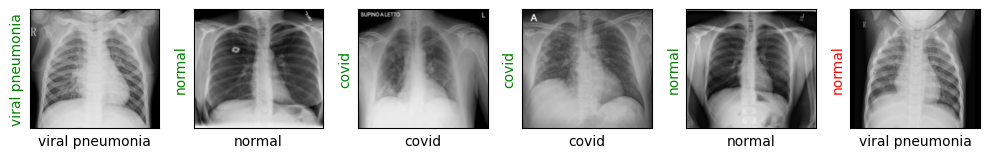

In [20]:
showpredictions()